<a href="https://colab.research.google.com/github/kolaSamuel/Contextual-Query-Reformulation/blob/master/Open_Dialogue_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
!pip install pytorch-pretrained-bert
from pytorch_pretrained_bert import BertForQuestionAnswering
# !git clone https://github.com/OpenNMT/OpenNMT-py
# !cd OpenNMT-py
# !pip install -r OpenNMT-py/requirements.txt
# !python OpenNMT-py/preprocess.py -train_src OpenNMT-py/data/src-train.txt -train_tgt OpenNMT-py/data/tgt-train.txt -valid_src OpenNMT-py/data/src-val.txt -valid_tgt OpenNMT-py/data/tgt-val.txt -save_data OpenNMT-py/data/demo
!pip install OpenNMT-tf

In [0]:
# # # !onmt-main -h
# # from opennmt import models
# # help(models.sequence_to_sequence)
# from pytorch_pretrained_bert import 
# import goo

## Corefrence Resolution

In [0]:
#@title Version fighting and pip installs
!pip install --force-reinstall spacy==2.1.0
!pip install neuralcoref
# Load your usual SpaCy model (one of SpaCy English models)
!python -m spacy download en
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force
!pip install allennlp
# !git clone https://github.com/HLTCHKUST/Mem2Seq

In [0]:
#@title Imports
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
import spacy
import neuralcoref
from google.colab import files
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as stop
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
from allennlp import pretrained
import re
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Testing the neural coref model

nlp = spacy.load('en')

# load NeuralCoref and add it to the pipe of SpaCy's model
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

# You're done. You can now use NeuralCoref the same way you usually manipulate a SpaCy document and it's annotations.
doc = nlp(u'My sister has a dog. She loves him.')

print(doc._.has_coref)
doc._.coref_clusters
doc._.coref_resolved

True


'My sister has a dog. My sister loves a dog.'

In [0]:
from allennlp import pretrained
model = pretrained.neural_coreference_resolution_lee_2017()

results = model.predict("My sister has a dog. She loves him.")
print(model.coref_resolved("My sister has a dog. She loves him."), type(model.coref_resolved("My sister has a dog. She loves him.")))
results

100%|██████████| 59248617/59248617 [00:04<00:00, 13135101.27B/s]


My sister has a dog. My sister loves My sister. <class 'str'>


{'clusters': [[[0, 1], [6, 6], [8, 8]]],
 'document': ['My',
  'sister',
  'has',
  'a',
  'dog',
  '.',
  'She',
  'loves',
  'him',
  '.'],
 'predicted_antecedents': [-1, -1, 0, 1],
 'top_spans': [[0, 0], [0, 1], [6, 6], [8, 8]]}

In [0]:
doc.similarity(nlp(doc._.coref_resolved))

0.9740934608298534

In [0]:
#@title Reading the Dialoogues
with open('TREC++_Entity_index_TEST_input.txt') as file:
  inputData = file.readlines()

# with open('/content/gdrive/My Drive/Project/train-output.json') as file:
#   goldData = json.load(file)

# len(goldData)

In [0]:
files.upload()

In [0]:
stopwords = stop.words('english')

def spacy_tokenize(string, remove_stopwords=True):
  tokens = list()
  stopword_data = stopwords if remove_stopwords else set()
  doc = nlp(string)
  for token in doc:
    if token.lemma_.strip() not in stopword_data:
      tokens.append(token)
  return " ".join(token.text for token in tokens)

def resolvedAbbs(doc):
  pass

In [0]:
def coref_scorer(doc1, doc2, doc3):
  results  = 0
  count = 0
  for x, y, z in zip(nlp(doc1).sents, nlp(doc2).sents, nlp(doc3).sents):
    sent1 = nlp(spacy_tokenize(x.text))
    sent2, sent3 = nlp(spacy_tokenize(y.text)), nlp(spacy_tokenize(z.text))
    if sent2.text != sent3.text:
#       print(sent1, sent2, sep='\n')
      results += sent1.similarity(sent2)
      count += 1
  
  return results/count if count else np.nan

In [0]:
# A way we can control a parameter
nlp.remove_pipe("neuralcoref")  # This remove the current neuralcoref instance from SpaCy pipe
coref = neuralcoref.NeuralCoref(nlp.vocab, greedyness=0.55)
nlp.add_pipe(coref, name='neuralcoref')

#allennlp pretrained end to end corefence resolution
model = pretrained.neural_coreference_resolution_lee_2017()

neural_resolvedData = []
# neural_accuracy = []
allen_resolvedData = []
# allen_accuracy = []
skips = 0

for dialogue  in tqdm(inputData):
  dialogue =dialogue.replace('<user>', '1@$%').replace('<system>', '1@$%')
  neural_resolved = nlp(dialogue)._.coref_resolved
  try:
    allen_resolved = model.coref_resolved(dialogue)
  except:
    allen_resolved = dialogue
    skips+=1
  
  
  neural_resolvedData.append(neural_resolved)
#   neural_accuracy.append(coref_scorer(neural_resolved, gold, dialogue))
  allen_resolvedData.append(allen_resolved)
#   allen_accuracy.append(coref_scorer(allen_resolved, gold, dialogue))

results = pd.DataFrame.from_dict({'Dialogue':inputData,
                                  'Neural Resolved Data': neural_resolvedData, 
                                  'Allen Resolved Data': allen_resolvedData,
                                 })
display(skips, results)



100%|██████████| 66/66 [00:05<00:00, 12.38it/s]


1

,Dialogue,Neural Resolved Data,Allen Resolved Data
0,<user> tell me about the types of irregular he...,1@$% tell me about the types of irregular hear...,1@$% tell me about the types of irregular hear...
1,<user> what are entity_1? <system> what are s...,1@$% what are entity_1? 1@$% what are some ex...,1@$% what are entity_1? 1@$% what are some ex...
2,<user> what defines a entity_1? <system> how ...,1@$% what defines a entity_1? 1@$% how are a ...,1@$% what defines a entity_1? 1@$% how are a ...
3,<user> what are the best ways to cook a entit...,1@$% what are the best ways to cook a entity_...,1@$% what are the best ways to cook a entity_...
4,<user> what is entity_1 exactly? <system> how...,1@$% what is entity_1 exactly? 1@$% how is it...,1@$% what is entity_1 exactly? 1@$% how is it...
5,<user> tell me about entity_1.\n,1@$% tell me about entity_1.\n,1@$% tell me about entity_1.\n
6,<user> what is a normal entity_1? <system> wh...,1@$% what is a normal entity_1? 1@$% what doe...,1@$% what is a normal entity_1? 1@$% what doe...
7,<user> tell me about the international entity...,1@$% tell me about the international entity_1...,1@$% tell me about the international entity_1...
8,<user> what is chemical energy? <system> desc...,1@$% what is chemical energy? 1@$% describe a...,1@$% what is chemical energy? 1@$% describe a...
9,<user> why is entity_2 important? <system> wh...,1@$% why is entity_2 important? 1@$% why shou...,1@$% why is entity_2 important? 1@$% why shou...


In [0]:
with open('Pred-Neural.txt', 'w')as f:
  print(*[x.split('1@$%')[-1].strip() for x in neural_resolvedData],
        sep='\n', file=f)
with open('Pred-Allen.txt', 'w')as f:
  print(*[x.split('1@$%')[-1].strip() for x in allen_resolvedData],
        sep='\n', file=f)

In [0]:
# print(*nlp(d2).sents, sep='\n')
# print()
# print(*nlp(d4).sents, sep='\n')
results[results['Allen Accuracy'] == 0]

In [0]:
print(results['Allen Accuracy'].describe())
results['Neural Accuracy'].describe()

count    1315.000000
mean        0.804020
std         0.113872
min         0.000000
25%         0.730045
50%         0.814538
75%         0.888122
max         0.991586
Name: Allen Accuracy, dtype: float64


count    1315.000000
mean        0.812702
std         0.106028
min         0.451302
25%         0.738119
50%         0.825427
75%         0.897927
max         1.000000
Name: Neural Accuracy, dtype: float64

In [0]:
import pandas as pd
test = pd.DataFrame.from_dict({'A':[1, 2, 3, 4, 5, 6] , 'B':[ 'I am a boy', 'is this hot', 'typing a word', 'fifty is a number', 'boy do you think', 'last sentence']})
test

In [0]:
test2  = test[(test['A']%2 == 0) | test['B'].str.contains(r'boy', na=True)]

## Mem to Seq

In [0]:
#Changing directory to Mem2Seq
import os
os.chdir('Mem2Seq')

!git clone https://github.com/HLTCHKUST/Mem2Seq

Cloning into 'Mem2Seq'...
remote: Enumerating objects: 266, done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (266/266), 8.04 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [0]:
!python3 main_train.py -lr=0.001 -layer=1 -hdd=128 -dr=0.2 -dec=Mem2Seq -bsz=8 -ds=kvr -t=

{'dataset': 'kvr', 'task': '', 'decoder': 'Mem2Seq', 'hidden': '128', 'batch': '8', 'learn': '0.001', 'drop': '0.2', 'unk_mask': 1, 'layer': '1', 'limit': -10000, 'path': None, 'test': None, 'sample': None, 'useKB': 1, 'entPtr': 0, 'evalp': 2, 'addName': ''}
07-08 16:19 Reading lines from data/KVR/train.txt
07-08 16:19 Pointer percentace= 0.4208753595747005 
07-08 16:19 Max responce Len: 80
07-08 16:19 Max Input Len: 249
07-08 16:19 Avg. User Utterances: 2.593814432989691
07-08 16:19 Avg. Bot Utterances: 2.593814432989691
07-08 16:19 Avg. KB results: 64.69896907216494
07-08 16:19 Avg. responce Len: 8.732273449920509
Sample:  [['dish_parking', 'poi', 'parking_garage', 'road_block_nearby', '2_miles'], ['2_miles', 'distance', 'dish_parking', 'PAD', 'PAD'], ['road_block_nearby', 'traffic_info', 'dish_parking', 'PAD', 'PAD'], ['parking_garage', 'poi_type', 'dish_parking', 'PAD', 'PAD'], ['550_alester_ave', 'address', 'dish_parking', 'PAD', 'PAD'], ['stanford_oval_parking', 'poi', 'parking_g

In [0]:
!python3 main_test.py -path=save/mem2seq-KVR/HDD128BSZ8DR0.2L1lr0.001Mem2Seq10.05 -dec=Mem2Seq -bsz=8 -ds=kvr

In [0]:
import os

path = 'save\\mem2seq-KVR'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk('save/mem2seq-KVR'):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)

In [0]:
a = 'save/mem2seq-KVR/HDD128BSZ8DR0.2L1lr0.001Mem2Seq10.05'
directory = a.split('/')
directory[2].split('HDD')

['', '128BSZ8DR0.2L1lr0.001Mem2Seq10.05']

In [0]:
# git clone https://github.com/kolaSamuel/Mem2Seq/tree/kolaSamuel-patch-1
# import os
os.chdir('../')
!rm -rf Mem2Seq
# os.mkdir('Samuel')
# os.chdir('Samuel')
!git clone --single-branch --branch kolaSamuel-patch-1 https://github.com/kolaSamuel/Mem2Seq
os.chdir('Mem2Seq')
!python3 main_test.py -path=save/mem2seq-KVR/HDD128BSZ8DR0.2L1lr0.001Mem2Seq12.03 -dec=Mem2Seq -bsz=8 -ds=kvr
# !rm -rf Mem2Seq

Cloning into 'Mem2Seq'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 297 (delta 13), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (297/297), 21.27 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (169/169), done.
{'dataset': 'kvr', 'task': None, 'decoder': 'Mem2Seq', 'hidden': None, 'batch': '8', 'learn': None, 'drop': None, 'unk_mask': 1, 'layer': None, 'limit': -10000, 'path': 'save/mem2seq-KVR/HDD128BSZ8DR0.2L1lr0.001Mem2Seq12.03', 'test': None, 'sample': None, 'useKB': 1, 'entPtr': 0, 'evalp': 2, 'addName': ''}
07-08 20:46 Reading lines from data/KVR/train.txt
07-08 20:46 Pointer percentace= 0.4208753595747005 
07-08 20:46 Max responce Len: 80
07-08 20:46 Max Input Len: 249
07-08 20:46 Avg. User Utterances: 2.593814432989691
07-08 20:46 Avg. Bot Utterances: 2.593814432989691
07-08 20:46 Avg. KB results: 64.69896907216494
07-08 20:46 Avg. responce Len: 8.73227344992

In [0]:
# !python3 main_test.py -path=save/mem2seq-KVR/HDD128BSZ8DR0.2L1lr0.001Mem2Seq12.03 -dec=Mem2Seq -bsz=8 -ds=kvr
ls save

HDD128BSZ8DR0.2L1lr0.001Mem2Seq11.92/  HDD128BSZ8DR0.2L1lr0.001Mem2Seq13.03/
HDD128BSZ8DR0.2L1lr0.001Mem2Seq12.03/


In [0]:
#@title Wikification
import urllib.parse, urllib.request, json

def CallWikifier(text, lang="en", threshold=0.8):
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "zqqxdqnjkbynbisnfsgkuzugboxuzg"),
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3"),
        ("partsOfSpeech", "true")
        ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    print(*response["nouns"], sep='\n')
    for annotation in response["annotations"]:
        print("%s (%s)" % (annotation["title"], annotation["url"]))

CallWikifier("Syria's foreign minister has said Damascus is ready to offer a prisoner exchange with rebels.")

{'iFrom': 0, 'iTo': 4, 'normForm': 'syria', 'synsetIds': []}
{'iFrom': 8, 'iTo': 23, 'normForm': 'foreign minister', 'synsetIds': ['110103794']}
{'iFrom': 16, 'iTo': 23, 'normForm': 'minister', 'synsetIds': ['100585810', '109983572', '110320695', '110320863']}
{'iFrom': 34, 'iTo': 41, 'normForm': 'damascus', 'synsetIds': []}
{'iFrom': 63, 'iTo': 70, 'normForm': 'prisoner', 'synsetIds': ['110476086']}
{'iFrom': 72, 'iTo': 79, 'normForm': 'exchange', 'synsetIds': ['100167063', '100167278', '100196485', '101093085', '101109467', '101166258', '101166517', '102994858', '103302487', '107134706', '111409538']}
{'iFrom': 86, 'iTo': 91, 'normForm': 'rebel', 'synsetIds': ['110210137', '110303654']}
Syria (http://en.wikipedia.org/wiki/Syria)
Damascus (http://en.wikipedia.org/wiki/Damascus)


In [0]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(u"7pm or 7pm")
print(doc.count_by, len(doc))
for token in doc:
  print(token, token.pos_)

<built-in method count_by of spacy.tokens.doc.Doc object at 0x7f0f92fea270> 5
7 NUM
pm NOUN
or CCONJ
7 NUM
pm NOUN


In [0]:
! rm OpenNMT-py.zip

# OpenNMT model

In [0]:
os.chdir('../')
!rm -rf OpenNMT-py
# !git clone https://github.com/kolaSamuel/OpenNMT-py-with-BERT.git
# os.chdir('OpenNMT-py')#-with-BERT')
# !pip install -r requirements.txt
# !git clone --branch OpenNMT https://github.com/kolaSamuel/alexa-dataset-contextual-query-rewrite

In [0]:
!git clone https://github.com/OpenNMT/OpenNMT-py.git
# !git clone https://github.com/shakeel608/OpenNMT-py-with-BERT.git
# !git clone https://github.com/nyu-dl/dl4ir-doc2query
# !git clone --branch Glove https://github.com/kolaSamuel/OpenNMT-py.git
!cd OpenNMT-py
import os
os.chdir('OpenNMT-py')
# os.chdir('OpenNMT-py-with-BERT')
!pip install -r requirements.txt
!git clone --branch CQR https://github.com/kolaSamuel/alexa-dataset-contextual-query-rewrite
# os.mkdir('opennmt_format')

Cloning into 'OpenNMT-py'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 14461 (delta 1), reused 8 (delta 0), pack-reused 14442
Receiving objects: 100% (14461/14461), 146.07 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (10339/10339), done.
  Cloning https://github.com/pytorch/text.git (to revision master) to /tmp/pip-req-build-3k3xk21d
  Running command git clone -q https://github.com/pytorch/text.git /tmp/pip-req-build-3k3xk21d
     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for configargparse: filename=ConfigArgParse-0.14.0-cp36-none-any.whl size=17503 sha256=5acb5a7b90bf70a7ff3443ed5dfc41a5ab4e422fd5c1e292180f26bd9b0dc457
  Stored in directory: /root/.cache/pip/wheels/aa/9c/ce/7e904dddb8c7595ffbe3409d24455bc5005852850e36011bda
  Created wheel for torchtext: filename=torchtext-0.4.0-cp36-none-any.whl size=53405 sha256=1573c751cd6582d3e99946bc3e72741e0737ba6

Cloning into 'alexa-dataset-contextual-query-rewrite'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 216 (delta 15), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (216/216), 5.75 MiB | 4.84 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [0]:
import os
# os.chdir('../')
# !mv *.pt OpenNMT-py
os.chdir('OpenNMT-py')
# os.chdir('OpenNMT-py-with-BERT')
# !pip install pytorch-pretrained-bert

In [0]:
# os.chdir('OpenNMT-py')
os.mkdir('./msmarco_data')
!wget https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz -P ./msmarco_data
!tar -xvf ./msmarco_data/collectionandqueries.tar.gz -C ./msmarco_data

Go  <a href='https://github.com/OpenNMT/OpenNMT-py/blob/master/docs/source/FAQ.md#how-do-i-use-the-transformer-model-do-you-support-multi-gpu'> Here </a>  for instructions on how to change models

In [0]:
!python ./preprocess.py \
  -train_src ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TRAIN_input.txt \
  -train_tgt ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TRAIN_output.txt \
  -valid_src ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TEST_input.txt \
  -valid_tgt ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TEST_output.txt \
  -save_data ./preprocessed \
  -share_vocab 
# -dynamic_dict

[2019-08-27 18:50:20,726 INFO] Extracting features...
[2019-08-27 18:50:20,727 INFO]  * number of source features: 0.
[2019-08-27 18:50:20,727 INFO]  * number of target features: 0.
[2019-08-27 18:50:20,727 INFO] Building `Fields` object...
[2019-08-27 18:50:20,727 INFO] Building & saving training data...
[2019-08-27 18:50:20,727 INFO] Reading source and target files: ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TRAIN_input.txt ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TRAIN_output.txt.
[2019-08-27 18:50:20,727 INFO] Building shard 0.
[2019-08-27 18:50:20,731 INFO]  * saving 0th train data shard to ./preprocessed.train.0.pt.
[2019-08-27 18:50:20,753 INFO]  * tgt vocab size: 148.
[2019-08-27 18:50:20,753 INFO]  * src vocab size: 303.
[2019-08-27 18:50:20,753 INFO]  * merging src and tgt vocab...
[2019-08-27 18:50:20,754 INFO]  * merged vocab size: 314.
[2019-08-27 18:50:20,755 INFO] Building & saving validation data...
[2019-08-27 18:50:20,755 INFO] Re

In [0]:
#@title Glove Embeddings
!mkdir "glove_dir"
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d "glove_dir"

!tools/embeddings_to_torch.py -emb_file_both "glove_dir/glove.6B.100d.txt" \
-dict_file "preprocessed.vocab.pt" \
-output_file "data/embeddings"

In [0]:
#@title RNN model
!python -u ./train.py  \
        -data preprocessed \
        -save_model CQR_valid_100\
        -train_steps 20000 \
        -rnn_size 128 \
        -word_vec_size 128 \
        -encoder_type rnn \
        -decoder_type rnn \
        -optim adagrad \
        -learning_rate 0.15 \
        -share_embeddings \
        -valid_steps 100 \
        -save_checkpoint_steps 1000\
        -log_file log.txt
#         -pre_word_vecs_enc "data/embeddings.enc.pt" \
#         -pre_word_vecs_dec "data/embeddings.dec.pt" \
#         -copy_attn \

In [0]:
#@title Transformer model
!python  train.py -data preprocessed -save_model CQR_TREC_split_60_40_lr_15 \
        -layers 6 -rnn_size 512 -word_vec_size 512 -transformer_ff 2048 -heads 8  \
        -encoder_type transformer -decoder_type transformer -position_encoding \
        -train_steps 10000  -max_generator_batches 2 -dropout 0.1 \
        -batch_size 256 -batch_type tokens -normalization tokens  -accum_count 2 \
        -optim adam -adam_beta2 0.998 -decay_method noam -warmup_steps 800 -learning_rate 0.15 \
        -max_grad_norm 0 -param_init 0  -param_init_glorot \
        -label_smoothing 0.1 -valid_steps 100 -save_checkpoint_steps 1000 -log_file log.txt \
        -train_from CQR_step_7000.pt



[2019-08-27 18:50:27,531 INFO] Loading checkpoint from CQR_step_7000.pt
[2019-08-27 18:50:27,910 INFO] Loading vocab from checkpoint at CQR_step_7000.pt.
[2019-08-27 18:50:27,910 INFO]  * src vocab size = 2088
[2019-08-27 18:50:27,910 INFO]  * tgt vocab size = 2088
[2019-08-27 18:50:27,910 INFO] Building model...
[2019-08-27 18:50:28,485 INFO] NMTModel(
  (encoder): TransformerEncoder(
    (embeddings): Embeddings(
      (make_embedding): Sequential(
        (emb_luts): Elementwise(
          (0): Embedding(2088, 512, padding_idx=1)
        )
        (pe): PositionalEncoding(
          (dropout): Dropout(p=0.1)
        )
      )
    )
    (transformer): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linear_keys): Linear(in_features=512, out_features=512, bias=True)
          (linear_values): Linear(in_features=512, out_features=512, bias=True)
          (linear_query): Linear(in_features=512, out_features=512, bias=True)
          

In [0]:
# # # !zip -r /content/OpenNMT-py.zip /content/OpenNMT-py
# # from google.colab import files
# # files.download("OpenNMT-py.zip")
# import os
# os.chdir('OpenNMT-py')
ls

In [0]:
!python ./translate.py \
                     -gpu 0 \
                     -model ./onmt/CQR_TREC_split_60_40_lr_15_step_8000.pt \
                     -src ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TEST_input.txt \
                     -tgt ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TEST_output.txt \
                     -output ./pred-Entity-8000-TEST.txt \
                     -replace_unk \
                     -verbose \
                     -report_time \
                     -beam_size 1

# !python ./translate.py \
#                      -gpu 0 \
#                      -model ./CQR_TREC_step_7500.pt \
#                      -src ./alexa-dataset-contextual-query-rewrite/TREC_TEST_input.txt \
#                      -replace_unk \
#                      -verbose \
#                      -report_time \
#                      -beam_size 1

[2019-08-29 00:23:41,407 INFO] Translating shard 0.

SENT 1: ['<user>', 'tell', 'me', 'about', 'the', 'types', 'of', 'irregular', 'heart', 'beat.']
PRED 1: tell me about the types types of of
PRED SCORE: -0.1024
GOLD 1: tell me about the types of <unk> <unk> <unk>
GOLD SCORE: -17.3571

SENT 2: ['<user>', 'what', 'are', 'entity_1?', '<system>', 'what', 'are', 'some', 'examples?', '<user>', 'describe', 'the', 'characteristics', 'of', 'entity_2', 'topology.', '<system>', 'what', 'routes', 'can', 'be', 'taken', 'by', 'an', 'upstream', 'packet?', '<user>', 'describe', 'core,', 'aggregator', 'and', 'edge', 'switches.']
PRED 2: describe and switches. switches. by entity_1?
PRED SCORE: -0.0855
GOLD 2: <unk> entity_2 <unk> <unk> and <unk> <unk>
GOLD SCORE: -21.7179

SENT 3: ['<user>', 'what', 'defines', 'a', 'entity_1?', '<system>', 'how', 'are', 'they', 'related', 'to', 'the', 'periodic', 'table?', '<user>', 'how', 'is', 'it', 'organised?', '<system>', 'how', 'does', 'a', 'chemical', 'compound

In [0]:
!perl ./tools/multi-bleu.perl \
    ./alexa-dataset-contextual-query-rewrite/TREC++_Entity_index_TEST_output.txt < pred-simple-8000-TEST.txt

BLEU = 13.44, 34.6/16.8/10.3/5.4 (BP=1.000, ratio=1.289, hyp_len=566, ref_len=439)


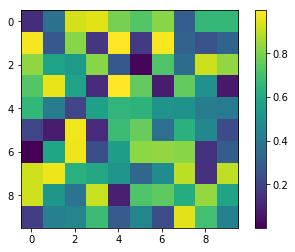

In [0]:
from string import ascii_letters
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.random.random((10,10)));
plt.colorbar()
plt.show()